In [34]:
from datasets import load_dataset

In [35]:
mnist = load_dataset("mnist")

In [36]:
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [37]:
img = mnist["train"]["image"][0]

In [38]:
import matplotlib as mpl

In [39]:
import matplotlib.pyplot as plt

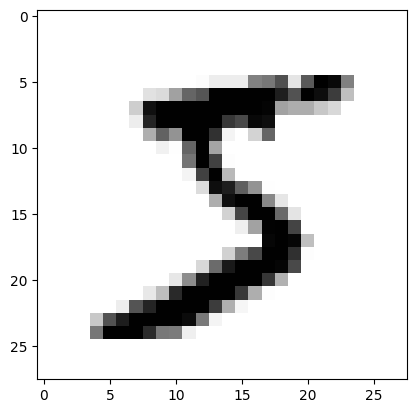

In [40]:
plt.imshow(img, cmap="gray_r")

In [41]:
mnist["train"]["label"][0]

5

Sử dụng ToTensor() của thư viện torchvision để convert pixel từ thang độ xám 256 về dạng chuẩn [0;1]

In [42]:
from torchvision import transforms

def mnist_to_tensor(samples):
    t = transforms.ToTensor()
    samples["image"] = [t(image) for image in samples["image"]]
    return samples

mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=1010)

In [43]:
mnist["train"]["image"][0].shape

torch.Size([1, 28, 28])

In [44]:
from torch.utils.data import DataLoader

In [45]:
bs = 64
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

Các lớp tích chập (convolutional layers) là tập hợp các bộ lọc 2D nhỏ, được áp dụng lặp đi lặp lại lên nhiều vùng khác nhau của ảnh đầu vào. Những bộ lọc này có thể phát hiện các mẫu như đường thẳng hoặc vùng hình tròn. Truyền thống trước đây, các bộ lọc 2D thường được sử dụng trong xử lý ảnh số, nơi chúng được thiết kế thủ công một cách cẩn thận để khớp với những đặc trưng cụ thể trong ảnh đầu vào.

Điểm khác biệt chính với các lớp tích chập là các bộ lọc không được chuẩn bị sẵn từ trước — thay vào đó, chúng được các lớp tích chập tự học trong quá trình huấn luyện mạng. Bằng cách xếp chồng nhiều lớp tích chập, mô hình có thể dần dần trích xuất ra các đặc trưng trừu tượng hơn từ ảnh đầu vào, học ra những bộ lọc giúp giải quyết bài toán một cách hiệu quả.

Có một lĩnh vực rất thú vị về giải thích và diễn giải mô hình, nhằm trực quan hóa và hiểu cách thức hoạt động bên trong của các lớp mạng. Thực tế đã cho thấy rằng các bộ lọc mà mạng nơ-ron học được đôi khi lại giống với các bộ lọc kinh điển do con người thiết kế thủ công để phát hiện cạnh, màu sắc, hoặc đường viền.

In [46]:
from torch import nn

In [47]:
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

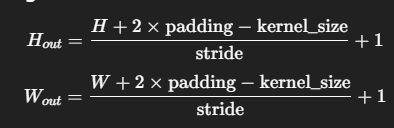

In [48]:
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256)
        self.conv3 = conv_block(256, 512)
        self.conv4 = conv_block(512, 1024) #(bs, 1024, 1, 1)
        self.linear = nn.Linear(1024, 16)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.linear(x.flatten(start_dim=1))
        return x

In [49]:
in_channels = 1
x = mnist["train"]["image"][0][None, :]
encoder = Encoder(in_channels).eval()
encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [50]:
encoded

tensor([[ 0.0139, -0.0002,  0.0265,  0.0358,  0.0004, -0.0059,  0.0079, -0.0075,
          0.0115, -0.0266,  0.0028,  0.0078, -0.0202, -0.0094,  0.0051,  0.0272]],
       grad_fn=<AddmmBackward0>)

In [51]:
batch = next(iter(train_dataloader))

In [52]:
batch.shape

torch.Size([64, 1, 28, 28])

In [53]:
encoded = Encoder(1)(batch)

In [54]:
encoded.shape

torch.Size([64, 16])

In [55]:
def conv_transpose_block(
    in_channels,
    out_channels,
    kernel_size=3,
    stride=2,
    padding=1,
    output_padding=0,
    with_act=True,
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
    ]
    if with_act:
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
    return nn.Sequential(*modules)

In [56]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.linear = nn.Linear(
            16, 1024 * 4 * 4
        )
        self.t_conv1 = conv_transpose_block(1024, 512)
        self.t_conv2 = conv_transpose_block(512, 256, output_padding=1)
        self.t_conv3 = conv_transpose_block(256, out_channels, output_padding=1)
    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x) # (bs, 1024*4*4)
        x = x.reshape((bs, 1024, 4, 4)) # (bs, 1024, 4, 4)
        x = self.t_conv1(x) # (bs, 512, 7, 7)
        x = self.t_conv2(x) # (bs, 256, 14, 14)
        x = self.t_conv3(x) # (bs, 1, 28, 28)
        return x

In [57]:
decoded_batch = Decoder(x.shape[0])(encoded)

In [58]:
decoded_batch.shape

torch.Size([64, 1, 28, 28])

In [59]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = Decoder(in_channels)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))
        

In [60]:
model = AutoEncoder(1)

In [61]:
import torchsummary

In [62]:
torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [63]:
import torch
from tqdm.notebook import tqdm, trange
from torch.nn import functional as F

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [65]:
num_epochs = 10
lr = 1e-4

model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

losses = []
for _ in (progress := trange(num_epochs, desc="Training")):
    for _, batch in (
        inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    ):
        batch = batch.to(device)
        preds = model(batch)
        loss = F.mse_loss(preds, batch)
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

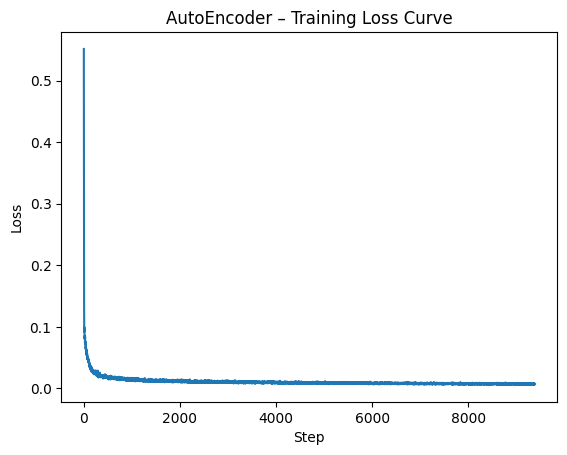

In [66]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("AutoEncoder – Training Loss Curve")
plt.show()

Test

In [67]:
eval_bs = 16
eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_bs)

In [71]:
model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = model(eval_batch.to(device)).cpu()

In [74]:
batch_vs_preds = torch.cat((eval_batch, predicted))

In [76]:
images = batch_vs_preds.numpy()  # chuyển từ tensor sang numpy

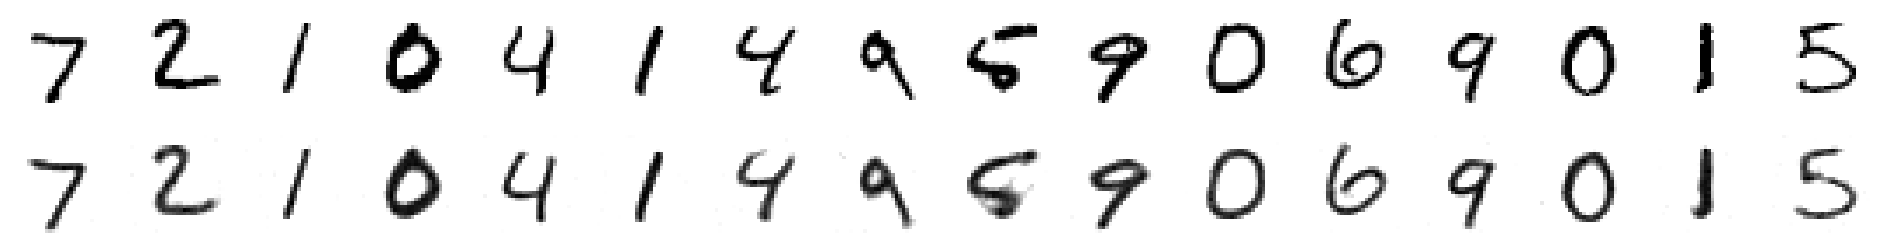

In [78]:
bs = eval_bs
fig, axes = plt.subplots(2, bs, figsize=(bs*1.5, 3))

for i in range(bs):
    # ảnh gốc
    axes[0, i].imshow(batch_vs_preds[i, 0], cmap="gray_r")
    axes[0, i].axis("off")
    
    # ảnh tái tạo
    axes[1, i].imshow(batch_vs_preds[i + bs, 0], cmap="gray_r")
    axes[1, i].axis("off")

plt.show()